In [2]:
import pandas as pd
import textstat

temps = [0.2, 0.5, 0.7]

for t in temps:
    # Define file paths
    input_path = f"Result_RQ2/{t}_desc_RQ2.csv"
    output_path = f"Result_RQ2/{t}_desc_RQ2_fog.csv"

    # Load CSV
    df = pd.read_csv(input_path)

    # --- Clean up and handle NaNs ---
    df['Generated_Description'] = df['Generated_Description'].fillna("").astype(str)

    # --- Compute Gunning Fog per row ---
    df['fog_index'] = df['Generated_Description'].apply(
        lambda x: textstat.gunning_fog(x) if x.strip() else 0
    )

    # --- Average per library (merge Source info) ---
    df_avg = (
        df.groupby(['Lib_Name', 'Source'], as_index=False)['fog_index']
        .mean()
        .rename(columns={'fog_index': 'mean_fog_index'})
    )

    # --- Print summary by tier ---
    avg_fog_by_source = df_avg.groupby('Source')['mean_fog_index'].mean()
    print(f"\nTemperature {t}")
    for tier, value in avg_fog_by_source.items():
        print(f"Avg_Fog_{tier.capitalize()} = {value:.2f}")

    # --- Save result ---
    df_avg.to_csv(output_path, index=False)

print("\n✅ Done! Mean Gunning Fog Index per Lib_Name saved for all temperatures.")



Temperature 0.2
Avg_Fog_Bottom = 18.81
Avg_Fog_Middle = 18.11
Avg_Fog_Top = 16.85

Temperature 0.5
Avg_Fog_Bottom = 18.86
Avg_Fog_Middle = 18.14
Avg_Fog_Top = 16.89

Temperature 0.7
Avg_Fog_Bottom = 18.76
Avg_Fog_Middle = 18.19
Avg_Fog_Top = 16.95

✅ Done! Mean Gunning Fog Index per Lib_Name saved for all temperatures.


Gunning Fog Index for human written description.

In [5]:
import pandas as pd
import textstat

# Load CSV
df = pd.read_csv("descriptions_output.csv")

# Ensure descriptions are strings, replacing NaN with empty string
df["description"] = df["description"].fillna("").astype(str)

# Compute Gunning Fog safely
df["fog_index"] = df["description"].apply(lambda x: textstat.gunning_fog(x) if x.strip() else 0)

# Save updated file
df.to_csv("descriptions_output.csv", index=False)

print("✅ Done! Added 'fog_index' column to descriptions_output_fog.csv")
print(df.head())


✅ Done! Added 'fog_index' column to descriptions_output_fog.csv
       library source                                        description  \
0  body-parser    top                    Node.js body parsing middleware   
1     inflight    top  Add callbacks to requests in flight to avoid a...   
2   mime-types    top      The ultimate javascript content-type utility.   
3      mime-db    top                                Media Type Database   
4   ansi-regex    top  Regular expression for matching ANSI escape codes   

   fog_index  
0  11.600000  
1   8.000000  
2  34.000000  
3  27.866667  
4  14.228571  


In [6]:
import pandas as pd

# Load human dataset
human = pd.read_csv("descriptions_output.csv")  # library, source, description, fog_index
human.rename(columns={
    "library": "Lib_Name",
    "source": "Source",
    "fog_index": "human_fog_index"
}, inplace=True)

# Clean invalid rows (blank or 0 fog)
human = human[(human["human_fog_index"] > 0) & (human["description"].notna()) & (human["description"].str.strip() != "")]

temps = [0.2, 0.5, 0.7]
summary = []

for t in temps:
    print(f"\n=== Temperature {t} ===")
    ai_path = f"Result_RQ2/{t}_desc_RQ2_fog.csv"
    ai = pd.read_csv(ai_path)
    ai.rename(columns={"mean_fog_index": "ai_fog_index"}, inplace=True)

    # Merge human + AI
    merged = pd.merge(human[["Lib_Name", "Source", "human_fog_index"]],
                      ai[["Lib_Name", "Source", "ai_fog_index"]],
                      on=["Lib_Name", "Source"],
                      how="inner")

    # Compute difference
    merged["fog_diff"] = merged["ai_fog_index"] - merged["human_fog_index"]

    # Summary stats
    avg_h = merged["human_fog_index"].mean()
    avg_ai = merged["ai_fog_index"].mean()
    avg_diff = merged["fog_diff"].mean()

    print(f"Compared: {len(merged)} libs")
    print(f"Avg Human Fog: {avg_h:.2f}")
    print(f"Avg AI Fog: {avg_ai:.2f}")
    print(f"Avg Diff (AI - Human): {avg_diff:.2f}")

    # By Source
    tier_summary = merged.groupby("Source")[["human_fog_index", "ai_fog_index", "fog_diff"]].mean().round(2)
    print("\nBy Source:\n", tier_summary)

    # Save
    merged.to_csv(f"Result_RQ2/{t}_compare_fog.csv", index=False)
    summary.append({"Temperature": t, "Avg_Human_Fog": avg_h, "Avg_AI_Fog": avg_ai, "Avg_Diff": avg_diff})

# Combined summary
summary_df = pd.DataFrame(summary)
summary_df.to_csv("Result_RQ2/compare_fog_summary_all.csv", index=False)

print("\n✅ Done! Comparison files saved in Result_RQ2/")
print(summary_df)



=== Temperature 0.2 ===
Compared: 1459 libs
Avg Human Fog: 10.85
Avg AI Fog: 17.91
Avg Diff (AI - Human): 7.05

By Source:
         human_fog_index  ai_fog_index  fog_diff
Source                                         
bottom            10.59         18.78      8.19
middle            11.45         18.13      6.68
top               10.52         16.84      6.32

=== Temperature 0.5 ===
Compared: 1459 libs
Avg Human Fog: 10.85
Avg AI Fog: 17.96
Avg Diff (AI - Human): 7.10

By Source:
         human_fog_index  ai_fog_index  fog_diff
Source                                         
bottom            10.59         18.86      8.27
middle            11.45         18.14      6.69
top               10.52         16.89      6.37

=== Temperature 0.7 ===
Compared: 1459 libs
Avg Human Fog: 10.85
Avg AI Fog: 17.94
Avg Diff (AI - Human): 7.09

By Source:
         human_fog_index  ai_fog_index  fog_diff
Source                                         
bottom            10.59         18.72      8.14
m

Compare between AI and Human

In [ ]:
import pandas as pd

# Load human dataset
human = pd.read_csv("descriptions_output.csv")  # library, source, description, fog_index
human.rename(columns={
    "library": "Lib_Name",
    "source": "Source",
    "fog_index": "human_fog_index"
}, inplace=True)

# Clean invalid rows (blank or 0 fog)
human = human[(human["human_fog_index"] > 0) & (human["description"].notna()) & (human["description"].str.strip() != "")]

temps = [0.2, 0.5, 0.7]
summary = []

for t in temps:
    print(f"\n=== Temperature {t} ===")
    ai_path = f"Result_RQ2/{t}_desc_RQ2_fog.csv"
    ai = pd.read_csv(ai_path)
    ai.rename(columns={"mean_fog_index": "ai_fog_index"}, inplace=True)

    # Merge human + AI
    merged = pd.merge(human[["Lib_Name", "Source", "human_fog_index"]],
                      ai[["Lib_Name", "Source", "ai_fog_index"]],
                      on=["Lib_Name", "Source"],
                      how="inner")

    # Compute difference
    merged["fog_diff"] = merged["ai_fog_index"] - merged["human_fog_index"]

    # Summary stats
    avg_h = merged["human_fog_index"].mean()
    avg_ai = merged["ai_fog_index"].mean()
    avg_diff = merged["fog_diff"].mean()

    print(f"Compared: {len(merged)} libs")
    print(f"Avg Human Fog: {avg_h:.2f}")
    print(f"Avg AI Fog: {avg_ai:.2f}")
    print(f"Avg Diff (AI - Human): {avg_diff:.2f}")

    # By Source
    tier_summary = merged.groupby("Source")[["human_fog_index", "ai_fog_index", "fog_diff"]].mean().round(2)
    print("\nBy Source:\n", tier_summary)

    # Save
    merged.to_csv(f"Result_RQ2/{t}_compare_fog.csv", index=False)
    summary.append({"Temperature": t, "Avg_Human_Fog": avg_h, "Avg_AI_Fog": avg_ai, "Avg_Diff": avg_diff})

# Combined summary
summary_df = pd.DataFrame(summary)
summary_df.to_csv("Result_RQ2/compare_fog_summary_all.csv", index=False)

print("\n✅ Done! Comparison files saved in Result_RQ2/")
print(summary_df)


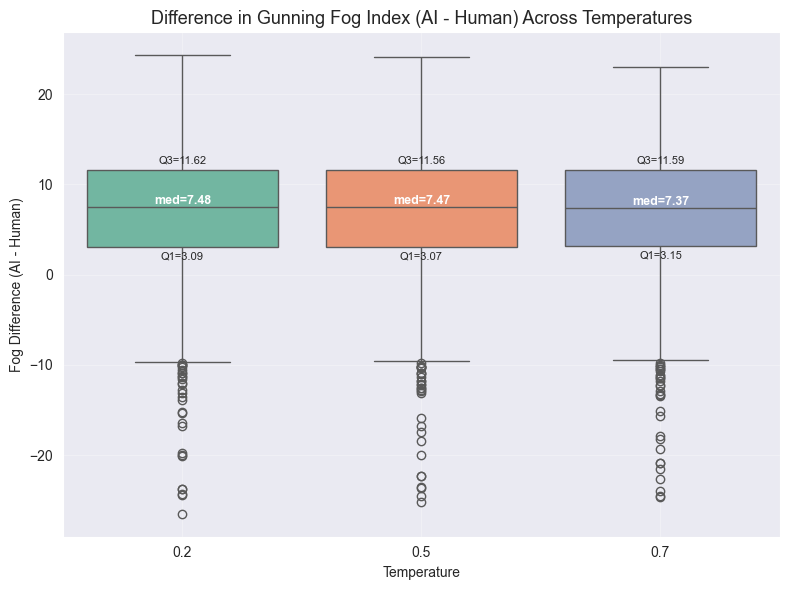

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

temps = [0.2, 0.5, 0.7]
combined = pd.DataFrame()

# --- Load and combine all comparison files ---
for t in temps:
    df = pd.read_csv(f"Result_RQ2/{t}_compare_fog.csv")
    df["Temperature"] = t
    combined = pd.concat([combined, df], ignore_index=True)

# --- Plot boxplot ---
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=combined,
    x="Temperature",
    y="fog_diff",
    hue="Temperature",      # explicitly set hue
    palette="Set2",
    legend=False            # hide duplicate legend
)


# Add median labels on each box
for i, t in enumerate(temps):
    med = combined.loc[combined["Temperature"] == t, "fog_diff"].median()
    q1 = combined.loc[combined["Temperature"] == t, "fog_diff"].quantile(0.25)
    q3 = combined.loc[combined["Temperature"] == t, "fog_diff"].quantile(0.75)
    plt.text(i, med, f"med={med:.2f}", ha="center", va="bottom", fontsize=9, fontweight="bold", color="white")
    plt.text(i, q1 - 0.5, f"Q1={q1:.2f}", ha="center", va="top", fontsize=8)
    plt.text(i, q3 + 0.5, f"Q3={q3:.2f}", ha="center", va="bottom", fontsize=8)

plt.title("Difference in Gunning Fog Index (AI - Human) Across Temperatures", fontsize=13)
plt.xlabel("Temperature")
plt.ylabel("Fog Difference (AI - Human)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


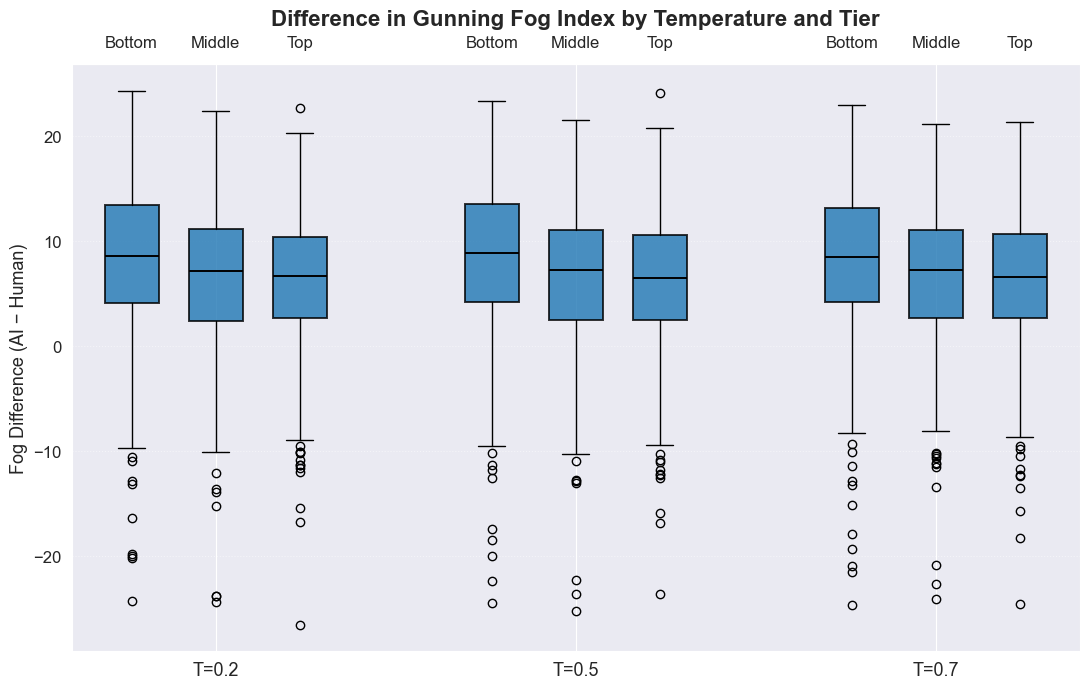

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
temps = [0.2, 0.5, 0.7]
tiers = ["Bottom", "Middle", "Top"]   # order within each temp group
data_dir = Path("Result_RQ2")
csv_tmpl = "{t}_compare_fog.csv"      # expects columns: Source, fog_diff

# === Load values per (temp, tier) ===
values = {}
for t in temps:
    df = pd.read_csv(data_dir / csv_tmpl.format(t=t))
    for tier in tiers:
        vals = df.loc[df["Source"].str.casefold() == tier.casefold(), "fog_diff"].dropna().tolist()
        values[(t, tier)] = vals

# === Layout ===
group_gap  = 3.0       # spacing between temperature groups
within_gap = 0.7       # spacing between tiers inside a group
width      = 0.45      # box width

fig, ax = plt.subplots(figsize=(11, 7))  # ⬅️ larger figure

# draw boxes tier-by-tier so positions are consistent
for tier_idx, tier in enumerate(tiers):
    positions = [i * group_gap + (tier_idx - 1) * within_gap for i in range(len(temps))]
    ax.boxplot(
        [values[(t, tier)] for t in temps],
        positions=positions,
        widths=width,
        patch_artist=True,
        boxprops=dict(linewidth=1.4, alpha=0.8),
        medianprops=dict(color="black", linewidth=1.4)
    )

# === bottom: temperature ticks centered per group ===
group_centers = [i * group_gap for i in range(len(temps))]
ax.set_xticks(group_centers)
ax.set_xticklabels([f"T={t}" for t in temps], fontsize=13, fontweight='medium')

# === top: tier labels ===
tier_positions = []
tier_names = []
for g in range(len(temps)):
    for tier_idx, tier in enumerate(tiers):
        tier_positions.append(group_centers[g] + (tier_idx - 1) * within_gap)
        tier_names.append(tier)

ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(tier_positions)
ax_top.set_xticklabels(tier_names, fontsize=12, fontweight='medium')
ax_top.tick_params(axis="x", length=0, pad=10)

# === Styling ===
ax.set_ylabel("Fog Difference (AI − Human)", fontsize=13, fontweight='medium')
ax.set_title("Difference in Gunning Fog Index by Temperature and Tier",
             fontsize=16, fontweight='bold', pad=28)
ax.tick_params(axis="y", labelsize=12)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)

plt.subplots_adjust(top=0.88, bottom=0.15)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
from scipy.stats import kruskal

temps = [0.2, 0.5, 0.7]

for t in temps:
    # Load per-temperature comparison file
    df = pd.read_csv(f"Result_RQ2/{t}_compare_fog.csv")

    # Extract fog_diff by Source tier
    top = df.loc[df["Source"].str.lower() == "top", "fog_diff"]
    middle = df.loc[df["Source"].str.lower() == "middle", "fog_diff"]
    bottom = df.loc[df["Source"].str.lower() == "bottom", "fog_diff"]

    # Run Kruskal–Wallis test
    stat, p_value = kruskal(top, middle, bottom)

    print(f"\n=== Temperature {t} ===")
    print(f"Kruskal–Wallis H-statistic: {stat:.3f}")
    print(f"p-value: {p_value:.4f}")

    # Interpret results
    if p_value < 0.05:
        print("→ Significant difference between Source tiers (reject H₀)")
    else:
        print("→ No significant difference between tiers (fail to reject H₀)")



=== Temperature 0.2 ===
Kruskal–Wallis H-statistic: 25.751
p-value: 0.0000
→ Significant difference between Source tiers (reject H₀)

=== Temperature 0.5 ===
Kruskal–Wallis H-statistic: 28.367
p-value: 0.0000
→ Significant difference between Source tiers (reject H₀)

=== Temperature 0.7 ===
Kruskal–Wallis H-statistic: 22.416
p-value: 0.0000
→ Significant difference between Source tiers (reject H₀)
